### Imports

The following cell imports all necessary libraries/modules

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

### Creating dataloader

Transforming the data and creating an useful dataloader object to use for training.

In [2]:
class SubsetSprites(Dataset):

    def __init__(
            self,
            images: str,
            labels: str,
            label: np.ndarray,
            transform=None,
    ):
        labels = np.load(labels)
        mask = []
        for encoding in labels:
            mask.append(np.array_equal(encoding, label))
        subset = np.load(images)[mask]
        images = torch.from_numpy(subset) / 255
        if transform:
            images = torch.stack([transform(image) for image in images])
        self.images = images.to(device)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx]

In [3]:
BATCH_SIZE = 64

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
class PermuteChannelsAxis:
    
    def __call__(self, x):
        return x.permute(2, 0, 1)

In [6]:
transforms = torchvision.transforms.Compose([
    PermuteChannelsAxis(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

In [7]:
images = os.path.join("data/sprites.npy")
labels = os.path.join("data/sprites_labels.npy")

label = 0

sprites = SubsetSprites(
    images=images,
    labels=labels,
    label=np.eye(1, 5, label)[0],
    transform=transforms
)

dataloader = DataLoader(
    dataset=sprites,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

### Looking at the data

In the following cells we take a look at the data

In [8]:
samples = next(iter(dataloader)).to("cpu")

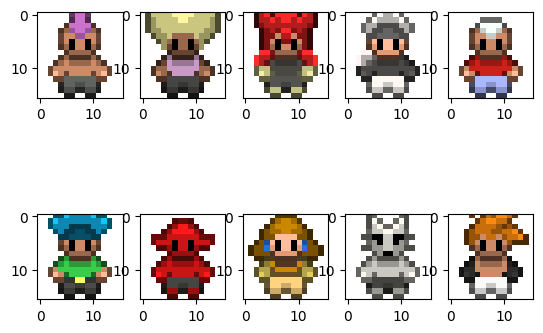

In [9]:
samples = samples[:10,:,:,:] / 2 + 0.5 # Undo the normalization when showing the images

fig, axis = plt.subplots(2, 5)
axis = axis.flatten()

for i in range(10):
    axis[i].imshow(samples[i].permute(1, 2, 0))

plt.show()

### Creating our networks

Creating the generator and discriminator network and it's necessary blocks and modules.

In [10]:
class PrintShape(nn.Module):
    """
    Neural network model used for debugging the shape.
    """

    def forward(self, x):
        print(x.shape)
        return x

In [11]:
class GeneratorBlock(nn.Module):

    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.conv_trans2d = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.layer_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(self.layer_norm(self.conv_trans2d(x)))

In [12]:
class Generator(nn.Module):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        n_G = 32
        self.net = nn.Sequential(
            GeneratorBlock(
                in_channels=100,
                out_channels=n_G * 4,
                kernel_size=4,
                stride=1,
                padding=0,
            ), # Output: BATCH_SIZE x 64 x 4 x 4
            GeneratorBlock(
                in_channels=n_G * 4,
                out_channels=n_G * 2,
                kernel_size=4,
                stride=2,
                padding=1,
            ), # Output: BATCH_SIZE x 32 x 8 x 8
            nn.ConvTranspose2d(
                in_channels=n_G * 2,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1
            ), nn.Tanh()  # Output: BATCH_SIZE x 3 x 16 x 16
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class DiscriminatorBlock(nn.Module):

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int,
            padding: int,
            alpha: float,
            **kwargs
    ):

        super().__init__(**kwargs)

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, x):
        return self.activation(self.batch_norm(self.conv(x)))

In [14]:
class Discriminator(nn.Module):

    def __init__(self, alpha: float, **kwargs):
        super().__init__(**kwargs)

        self.net = nn.Sequential(
            DiscriminatorBlock(
                in_channels=3,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                alpha=alpha,
            ),  # Output: BATCH_SIZE x 16 x 8 x 8
            DiscriminatorBlock(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1,
                alpha=alpha,
            ),  # Output: BATCH_SIZE x 32 x 4 x 4
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [15]:
class GAN:

    def __init__(
            self,
            alpha: float = 0.2,
            lr: float = 0.0002,
            betas: tuple[float, float] = (0.5, 0.999),
            checkpoint: dict = None
    ):
        
        self._gen = Generator().to(device)
        self._dis = Discriminator(alpha).to(device)
        
        self._gen_optim = torch.optim.Adam(
            params=self._gen.parameters(),
            lr=lr,
            betas=betas,
        )
        self._dis_optim = torch.optim.Adam(
            params=self._dis.parameters(),
            lr=lr,
            betas=betas,
        )
        
        if checkpoint:
            checkpoint = torch.load(checkpoint, map_location=device)
            self._gen.load_state_dict(checkpoint["gen"])
            self._dis.load_state_dict(checkpoint["dis"])
            self._gen_optim.load_state_dict(checkpoint["gen_optim"])
            self._dis_optim.load_state_dict(checkpoint["dis_optim"])
            self.epochs = checkpoint["epochs"]
        else:
            self.epochs = 0

        self._loss = nn.BCELoss()

    def train(
            self,
            data: DataLoader,
            epochs: int = 10,
            print_losses: bool = True,
    ):

        for epoch in range(epochs):
            D_losses = []
            G_losses = []

            for real_X in tqdm(data, f"Epoch {self.epochs + 1}"):

                batch_size = real_X.shape

                # Updating discriminator
                Z = torch.normal(0, 1, size=(BATCH_SIZE, 100, 1, 1), device=device)

                fake_X = self._gen(Z).detach()
                fake_Y = self._dis(fake_X)

                real_Y = self._dis(real_X)

                ones = torch.ones_like(real_Y)
                zeros = torch.zeros_like(fake_Y)

                D_loss = (self._loss(real_Y, ones) + self._loss(fake_Y, zeros)) / 2
                D_losses.append(D_loss)

                self._dis_optim.zero_grad()
                D_loss.backward()
                self._dis_optim.step()

                # Updating generator
                Z = torch.normal(0, 1, size=(BATCH_SIZE, 100, 1, 1), device=device)

                fake_X = self._gen(Z)
                fake_Y = self._dis(fake_X)

                ones = torch.ones_like(fake_Y)

                G_loss = self._loss(fake_Y, ones)
                G_losses.append(G_loss)

                self._gen_optim.zero_grad()
                G_loss.backward()
                self._gen_optim.step()
                
            self.epochs += 1

            if print_losses:
                print(f"Average discriminator loss: {sum(D_losses) / len(D_losses):5.2f}")
                print(f"Average generator loss: {sum(G_losses) / len(G_losses):5.2f}")

    def generate_images(self, images: int) -> torch.Tensor:

        Z = torch.normal(0, 1, size=(15, 100, 1, 1), device=device)

        with torch.no_grad():
            images = gan._gen(Z)
        
        return images.permute(0, 2, 3, 1)/2+0.5
    
    def save_checkpoint(self, path: str):
        checkpoint = {}
        checkpoint["gen"] = self._gen.state_dict()
        checkpoint["dis"] = self._dis.state_dict()
        checkpoint["gen_optim"] = self._gen_optim.state_dict()
        checkpoint["dis_optim"] = self._dis_optim.state_dict()
        checkpoint["epochs"] = self.epochs
        torch.save(checkpoint, path)

### Training the network

In [16]:
# Change from None to file path if want to load an existing checkpoint
# checkpoint = os.path.join("checkpoints", "checkpoint_23052025_n_G_64_1000_e.pt")
checkpoint = None

In [17]:
gan = GAN(
    alpha=0.2,
    lr=0.0002,
    betas=(0.5, 0.999),
    checkpoint=checkpoint
)

In [29]:
gan.train(
    data=dataloader,
    epochs=100,
    print_losses=False,
)

Epoch 200: 100%|██████████| 125/125 [00:01<00:00, 110.15it/s]


### Inspecting results
Checking if our model did pookie

In [34]:
images = gan.generate_images(15)

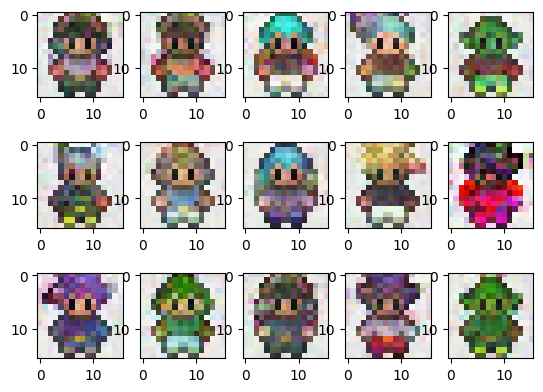

In [35]:
fig, axis = plt.subplots(3, 5)
axis = axis.flatten()

for i in range(15):
    axis[i].imshow(images.cpu()[i])

plt.show()

### Saving the model as a checkpoint

Saving the networks, and optimizers to continue training on another time point.

In [21]:
filename = "checkpoint_23052025_people_n_G_16_1000_e.pt"
path = os.path.join("checkpoints", filename)

In [22]:
gan.save_checkpoint(path)